# First, understand the data we are working with:
This dataset comes from "Predicting the Band Gaps of Inorganic Solids by Machine Learning" by Zhou et al (https://doi.org/10.1021/acs.jpclett.8b00124)

The supplement from his paper contains 2 different datasets. One is of experimental data points measuring the band-gaps of various ingorganic materials used to train their models. The other data set is a list of predictions of band gaps made from said models.

We should focus on the experimentla dataset, since these are the data points used to train the models.

According to the paper, there are two classes of materials included in the dataset: Metals (Bandgap = 0, conductors), and others materials (semiconductors, insulators: Eg> 0).

Here, we perform a superficial data curation on a previous paper in order to display how easy it is to miss many mistakes in chamical databases

In [2]:

#import needed packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist

In [3]:
# gather data for initial inspection 

PATH = os.getcwd()
data_path = PATH + '/BandGapData.csv'

df = pd.read_csv(data_path)
# look at the data frame
print("the size of the raw data is:" ,df.shape)
df.head(20)

the size of the raw data is: (6354, 2)


,composition,Eg (eV)
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44
5,PtSb2,0.08
6,ZnIn2S4,2.68
7,K2Cd3Te4,2.26
8,K4Sn3Ce3S14,2.46
9,Pb6B2CrO12,1.80


The size of our raw experimental data set is 6354 data points. With the composition as the independent variable and the band gap (Eg) as the dependent. Let's first look at the distribution of our independent variable:

Text(0, 0.5, 'Number of Materials')

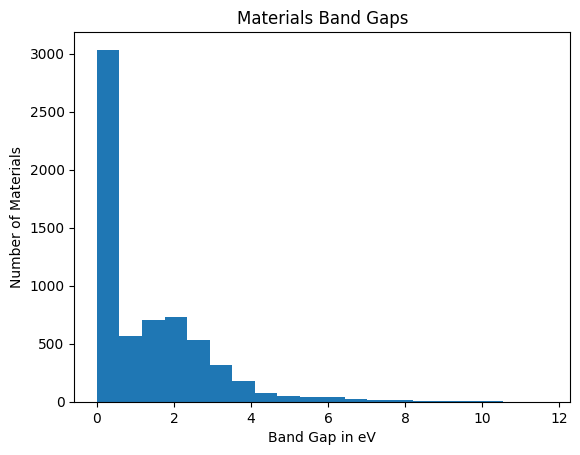

In [4]:

#make sure our data types are correct 
# set data as float
data_types_dict = {'Eg (eV)': float}

df = df.astype(data_types_dict)
#isolate independent variable  
BandGap = df['Eg (eV)']
# look at distribution
num_bins = 20
   
n, bins, patches = plt.hist(BandGap, num_bins)
plt.title('Materials Band Gaps')
plt.xlabel('Band Gap in eV')
plt.ylabel('Number of Materials')

There are a lot of metals (Eg = 0) in this dataset. We can get a better understanding of our distribution if we just look at materials with Eg>0:

Text(0, 0.5, 'Number of Materials')

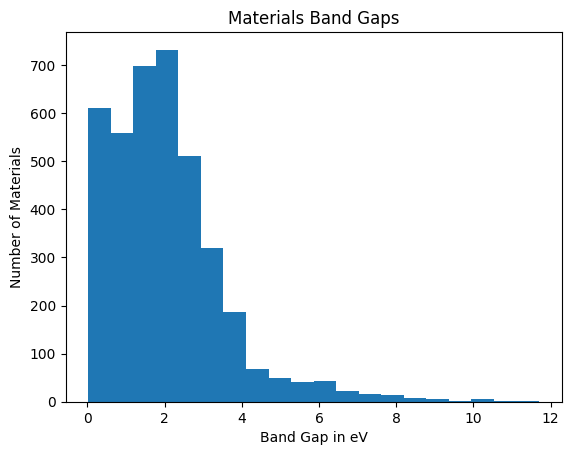

In [5]:
AboveZero = df[df['Eg (eV)']>0]
BandGap = AboveZero['Eg (eV)']
num_bins = 20
   
n, bins, patches = plt.hist(BandGap, num_bins)
plt.title('Materials Band Gaps')
plt.xlabel('Band Gap in eV')
plt.ylabel('Number of Materials')

We can see that most of the data point lie below 4eV. If this were a modeling exercise, we would have to be very weary of how we interpret our results for band gaps above 4 eV.

# Manual inspection of data
6000 data points is too many for manual inspection, so we should take a random sample from the following subsets:

Bandgaps above 4.0eV
Bandgaps = 0.0eV
Bandgaps greater than zero and less than 4
There are many ways we could inspect our data, but we should keep in mind that this is a laborious task and that our time is limited. One way of doing this is to pick 200 or so data points to manually inspect with rigor. This can be done in any spreadsheet editor.

In [6]:
# Separate out needed subsets
LargeBG = df[df['Eg (eV)']>4.0]
Zeros = df[df['Eg (eV)'] == 0.0]
BGs = df[df['Eg (eV)'] > 0.0]
BGs = BGs[BGs['Eg (eV)']<4.0]

# Get random samples from these subsets
LBGsInspect = LargeBG.sample(n=50)
ZsInspect = Zeros.sample(n=150)
BGsInspect = BGs.sample(n=150)

# save each to a csv for manual inspection
LBGsInspect.to_csv(PATH+"/large_bandgaps_for_inspection.csv")
ZsInspect.to_csv(PATH+"/Zeros_for_inspection.csv")
BGsInspect.to_csv(PATH+"/Bandgaps_for_inspection.csv")

These data sets shoudl be inspected in a separate sreadsheet editor.

Here are the types of errors and causes for suspicion found from manual inspection:

Duplicate enties with different Eg measurements
Misplaced commas in the chemical formula
Several materials whose mention could not be found elswhere in literature
Some materials are referenced two different ways (SnSi and SiSn, for example)

In [7]:
# Repair one formula that does not fit into any category of error 
df.replace("GaAs0.1P0.9G1128", "GaAs0.1P0.9", inplace=True)

In [8]:
# drop the misplaced commas and numbers from the formula 
df['Comp'] = df['composition'].str.split(',').str[0]

#how many compunds with commas 
print(len(df[df['composition'].str.contains(',')]),"data points with erroneous commas")
#drop column with commas
df = df.drop(['composition'], axis=1)

323 data points with erroneous commas


In [9]:

# have a look at the duplicates 
a = df.duplicated(subset = 'Comp',keep=False)

dupdf= df[a]


mats = pd.unique(dupdf['Comp'])
print(len(dupdf),'duplicate entries ',len(mats),"formula")
dupdf

1878 duplicate entries  458 formula


,Eg (eV),Comp
0,0.35,Hg0.7Cd0.3Te
1,3.08,CuBr
3,0.40,Cu3SbSe4
4,3.44,ZnO
5,0.08,PtSb2
...,...,...
5263,0.00,Li4Cu(PO4)2
5368,0.00,LiCo(CO3)2
5749,0.00,Li2Ti3FeO8
5806,0.00,LiCuPO4


It looks like there are 1878 duplicates in the dataframe. The duplicates of materials with a band gap equal to zero have to have all duplicaters eliminated except for one.

In [10]:

#Separate out the entries with band gap = 0 

zeros = dupdf.loc[dupdf['Eg (eV)'] == 0]
nonzeros=  dupdf.loc[dupdf['Eg (eV)'] > 0]

# get list of materials to drop from dataframe 
zeroMats= zeros['Comp']

In [11]:
print("number of nonzero duplicates {} \nnumber of zero duplicates {} ".format(len(nonzeros),len(zeros)))


number of nonzero duplicates 1864 
number of zero duplicates 14 


In [12]:
#drop all duplicates from the original dataframe

df = df.drop_duplicates(['Comp'])
df.to_csv("dfDropped.csv")

print("size of the original dataframe after removing all duplicates at first:{}".format(len(df)))

size of the original dataframe after removing all duplicates at first:4934


In [13]:
# drop one duplicate from list of Eg = 0 entries
zeros = zeros.drop_duplicates(keep='first')
print(len(zeros),"Eg=0 entries after duplicate analysis")

7 Eg=0 entries after duplicate analysis


It looks as though the duplicate entries for Eg>0 are due to the fact that differnt crystal structures of the same material will result in different band gaps. However, the current 1D representation of materials we are using cannot tell the difference between crystal structures. Any modeling study that uses only these 1D representaions will produce a model that has very little real-world usability.

For the sake of curation, we can average the duplicate entries to address the problem of having duplicate entries in our dataset, but anyone interested in creating more detailed and useful models should harvest the 3D crystal strucutres of these materials. The code for doing so will come at the end of this notebook

In [14]:
# average the duplicates 
averaged = nonzeros.groupby(['Comp']).mean()

averaged.to_csv('averaged.csv')
# round the mean values 
averaged=averaged.round(2)


print("number of entries after being averaged: {}".format(len(averaged)))

number of entries after being averaged: 451


In [15]:
# place everything back into the original dataframe

cleaned1 = pd.concat([df,averaged], axis =0)

cleaned1.to_csv("cleaned1.csv")

cleaned = pd.concat([cleaned1,zeros],axis =0)

#save cleaned data to csv 

# excel sheet is edited to fix formula "GaAs0.1P0.9G1128" to "GaAs0.1P0.9"
cleaned.replace("GaAs0.1P0.9G1128", "GaAs0.1P0.9", inplace=True)


cleaned = cleaned.sort_values(by='Eg (eV)', ascending =False)
cleaned = cleaned.dropna()
cleaned =cleaned.reset_index(drop=True)

For good measure, and for addressing the fact that there are instances of the same materials being referred to by two different formulas, we can look for duplicates via descriptors.

In [16]:
from pymatgen.core import Composition

In [18]:

# import needed modules from packages
from matminer.featurizers.composition.element import ElementFraction
ef = ElementFraction()
from pymatgen.core import Composition

In [19]:


comp = []
for value in cleaned['Comp']:
  #print(value)
  comp.append(Composition(value))




cleaned['composition'] = comp
cleaned

,Eg (eV),Comp,composition
0,11.70,LiF,"(Li, F)"
1,11.10,MgF2,"(Mg, F)"
2,10.50,NaF,"(Na, F)"
3,10.40,RbF,"(Rb, F)"
4,10.39,BeO,"(Be, O)"
...,...,...,...
4936,0.00,NiP4O12,"(Ni, P, O)"
4937,0.00,Sm2P3Pt6,"(Sm, P, Pt)"
4938,0.00,CaZn2,"(Ca, Zn)"
4939,0.00,Nd4Ge3Rh4,"(Nd, Ge, Rh)"


In [20]:

#calculate elemental descriptors
Desc = ef.featurize_dataframe(cleaned,'composition',ignore_errors=True)

ElementFraction: 100%|██████████| 4941/4941 [00:02<00:00, 2465.40it/s]


In [21]:
Desc

,Eg (eV),Comp,composition,H,He,Li,Be,B,C,N,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
0,11.70,LiF,"(Li, F)",0.0,0,0.5,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,11.10,MgF2,"(Mg, F)",0.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,10.50,NaF,"(Na, F)",0.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,10.40,RbF,"(Rb, F)",0.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,10.39,BeO,"(Be, O)",0.0,0,0.0,0.5,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936,0.00,NiP4O12,"(Ni, P, O)",0.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4937,0.00,Sm2P3Pt6,"(Sm, P, Pt)",0.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4938,0.00,CaZn2,"(Ca, Zn)",0.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4939,0.00,Nd4Ge3Rh4,"(Nd, Ge, Rh)",0.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


To find duplicates in this way, we look for the materials that have no distance between them in descriptor space. We can use scipy to calculate the distance between each material

In [22]:

desc = Desc.drop(['composition','Eg (eV)', 'Comp'],axis=1)

dist = pd.DataFrame(squareform(pdist(desc.iloc[:, 1:])))

In [23]:
# we have a potential duplicate when there is a very low distance between points
#change matrix to numpy for faster runtime
Dist = dist.to_numpy()
flaglist = []
#iterate over top triangle of distance matrix 
q = len(Dist)
for i in range(1,q-1):
  for j in range(i+1,q):
    z = Dist[i][j]
    if z == 0.0:
      flaglist.append((i,j))
    else:
      continue

In [24]:

#inspect the mamterials that scored closely 
flagmats = []
materials = cleaned['Comp']
for i in flaglist:

  a = materials[i[0]]
  b = materials[i[1]]
  flagmats.append((a,b))

In [25]:

# look at the materials that are close in descriptor space
flagmats

[('B6P', 'B12P2'),
 ('Cs4Ta4P4Se24', 'Cs2Ta2P2Se12'),
 ('Cu1.8S', 'Cu9S5'),
 ('CuGa3Se5', 'Cu0.5Ga1.5Se2.5'),
 ('TeSe3', 'Se3Te'),
 ('In0.5P0.5Ga0.5As0.5', 'In0.5As0.5Ga0.5P0.5'),
 ('SeTe', 'Se0.5Te0.5'),
 ('Cu0.5In1.5Se2.5', 'CuIn3Se5'),
 ('GeSn', 'SnGe'),
 ('V2O4', 'VO2'),
 ('SnSi', 'SiSn'),
 ('Pb0.99Se0.99Sn0.01Se0.01', 'Pb0.99Sn0.01Se'),
 ('PbCoO3', 'CoPbO3'),
 ('Pb0.9Se0.9Sn0.1Se0.1', 'Pb0.9Sn0.1Se'),
 ('Pb0.85Se0.85Sn0.15Se0.15', 'Pb0.85Sn0.15Se'),
 ('Pb0.94Se0.94Sn0.06Se0.06', 'Pb0.94Sn0.06Se'),
 ('Pb0.95Se0.95Sn0.05Se0.05', 'Pb0.95Sn0.05Se'),
 ('LiCo(CO3)2', 'LiCo(CO3)2'),
 ('Li2MnCo3O8', 'Li2MnCo3O8'),
 ('Li2Ti3FeO8', 'Li2Ti3FeO8'),
 ('LiSn(PO3)4', 'LiSn(PO3)4'),
 ('Li2Fe3NiO8', 'Li2Fe3NiO8'),
 ('Li4Cu(PO4)2', 'Li4Cu(PO4)2'),
 ('LiCuPO4', 'LiCuPO4')]

In [26]:

# address the flags individually
df = cleaned

df=df.replace('B12P2','B6P')
df=df.replace('Cu1.8S','Cu9S5') 
df=df.replace('Cu0.5Ga1.5Se2.5','CuGa3Se5')
df=df.replace('SeTe','TeSe')
df=df.replace('In0.5As0.5Ga0.5P0.5','In0.5P0.5Ga0.5As0.5')
df=df.replace('Se0.5Te0.5','TeSe')
df=df.replace('Cu0.5In1.5Se2.5','CuIn3Se5')
df=df.replace('GeSn','SnGe')
df=df.replace('VO2','V2O4')
df=df.replace('SnSi','SiSn')
df=df.replace('Pb0.99Se0.99Sn0.01Se0.01','Pb0.99Sn0.01Se')
df=df.replace('PbCoO3','CoPbO3')
df=df.replace('Pb0.9Se0.9Sn0.1Se0.1','Pb0.9Sn0.1Se')
df=df.replace('Pb0.85Se0.85Sn0.15Se0.15', 'Pb0.85Sn0.15Se')
df=df.replace('Pb0.94Se0.94Sn0.06Se0.06', 'Pb0.94Sn0.06Se')
df=df.replace('Pb0.95Se0.95Sn0.05Se0.05', 'Pb0.95Sn0.05Se')

df = df.drop_duplicates(['Comp'])
#insepct the data frame again
df

,Eg (eV),Comp,composition
0,11.70,LiF,"(Li, F)"
1,11.10,MgF2,"(Mg, F)"
2,10.50,NaF,"(Na, F)"
3,10.40,RbF,"(Rb, F)"
4,10.39,BeO,"(Be, O)"
...,...,...,...
4936,0.00,NiP4O12,"(Ni, P, O)"
4937,0.00,Sm2P3Pt6,"(Sm, P, Pt)"
4938,0.00,CaZn2,"(Ca, Zn)"
4939,0.00,Nd4Ge3Rh4,"(Nd, Ge, Rh)"


To further ensure the quality of our dataset, we should only use materials formula that can be externally verified by at least one external source. For the purpose of this exercise, we can use the materils project as our external source. https://materialsproject.org/

If we cannot find the materials formula in the materials project, then we should drop it from our dataset.

In [32]:
# import some packages needed to collect new data 
import requests 

from pymatgen.ext.matproj import MPRester
import requests 
from pymatgen.ext.matproj import MPRester

KEY = 'lFdcJ0ITOlPeG0EGHvRPxx5ufEXvzbuy'

In [33]:

# make a function to return materials IDs of valid formulas
def getID(formula):
  with MPRester(KEY) as mpr:
    try:
      z =mpr.get_materials_ids(formula)
    except:
      z = None
  return z

use the MP API to collect the materials project IDs of the materials in our dataset. Note: collecting this information can take up to a couple of hours depending on the size of the dataset and the speed of the API.

In [34]:

from time import sleep
from tqdm import tqdm
# get list of materials in our dataset
mats = df['Comp']
mp_ID = []
for i in tqdm(mats):

  z =getID(i) 
  val = bool(z)
  if val==True:
    mp_ID.append(z)
  else:
    mp_ID.append(0)

100%|██████████| 4919/4919 [11:05<00:00,  7.39it/s]


In [35]:

# add the materials project ID to the dataframe


df['mp_ids'] = mp_ID

#keep only the materials that were verified by the MP

df_mps= df[df['mp_ids']!='0']

In [36]:
# look at our final dataset and save
df_mps.to_csv("CuratedBandGaps_MPIDs.csv")
df_mps

,Eg (eV),Comp,composition,mp_ids
0,11.70,LiF,"(Li, F)","[mp-1138, mp-1009009, mp-1185301]"
1,11.10,MgF2,"(Mg, F)","[mp-1072956, mp-560236, mp-1249, mp-1062842, m..."
2,10.50,NaF,"(Na, F)",[mp-682]
3,10.40,RbF,"(Rb, F)","[mp-2064, mp-11718]"
4,10.39,BeO,"(Be, O)","[mp-1244907, mp-1794, mp-1245079, mp-1244963, ..."
...,...,...,...,...
4936,0.00,NiP4O12,"(Ni, P, O)","[mp-26364, mp-540079, mp-32343, mp-695808, mp-..."
4937,0.00,Sm2P3Pt6,"(Sm, P, Pt)",[mp-570141]
4938,0.00,CaZn2,"(Ca, Zn)","[mp-13364, mp-1725]"
4939,0.00,Nd4Ge3Rh4,"(Nd, Ge, Rh)",[mp-3375]


If you wish only to do 1D modeling (only using the materials chemical formula), then here is you can stop curating. If you wish to gain some structural awareness in your model, you can use the materials project IDs that we collected to incorporate things like crystal structure and DFT properties. Dropping the entries without Materials Project data from this dataframe results in 3517 materials formula

# Conclusion

While superficial, this notebook demonstrates the number of possible errors that one can encounter. More worrisome, we show how they can easily slip under the radar without following rigorous data curation techniques .